In [ ]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading encoding features

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_balanced_training_sample_with_prederr10_encoding_features_chi2_turbofats_gband.csv')
data_train.set_index('oid_alerce',inplace=True)
#data = pd.read_csv('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_final_sample_with_prederr10_encoding_features_chi2_turbofats_gband.csv')
data = pd.read_csv('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_Frederick_Ricci_sample_with_prederr10_encoding_features_chi2_gband.csv')
data.set_index('oid',inplace=True)
#data.set_index('oid_alerce',inplace=True)

In [ ]:
#filtering data by ps_score
#data = data[(data.chi2_gband>3)]

In [ ]:
#defining features for the anomaly detection algorithm 
feat_list = [
             "e1", "e2", "e3", "e4", "e5", "e6", "e7", "e8","e9", "e10","e11",
               "e12", "e13", "e14", "e15", "e16",
             #"chi2_gband",
             #"mhps_ratio","mhps_low","mhps_high","Amplitude","Autocor_length","Meanvariance","GP_DRW_sigma","GP_DRW_tau","SF_ML_amplitude","SF_ML_gamma","IAR_phi","LinearTrend"
             ]

#saving features in df
df_feat = data[feat_list]
df_feat_train = data_train[feat_list]
df_feat.head()

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16
oid,,,,,,,,,,,,,,,,
405113200012094,-0.019421,-0.036640,1.555295,1.281783,-1.968677,-0.006785,-0.034409,0.006346,-0.036378,0.034309,-0.058941,0.025057,-0.040508,0.754415,-1.031383,0.012401
464105200007063,0.013039,0.040348,-2.174314,1.389187,1.373868,0.021756,0.003378,-0.007620,0.033752,-0.048393,0.040288,-0.041269,0.010209,-0.264444,0.098123,0.002398
516105400003751,-0.004812,-0.022248,0.782761,-0.180979,0.173506,0.012976,-0.016303,0.020130,0.005639,0.009286,-0.018461,0.024875,-0.007340,1.983115,2.298911,0.036256
629115200005576,0.005211,0.002847,0.081205,2.559672,0.830689,0.049800,-0.053007,0.017275,-0.012348,0.007815,-0.058085,0.009515,-0.046890,2.637215,-1.224063,0.019422
634110400007229,-0.026129,-0.045747,2.656521,2.428572,-2.103093,-0.015175,-0.031090,-0.007545,-0.034387,0.037459,-0.053233,0.017111,-0.031956,0.058569,0.104327,0.017647


## Anomaly detection with Isolation forest


In [ ]:
#Isolation model definition
model_isof = IsolationForest(
                n_estimators  = 500,
                max_samples   ='auto',
                contamination = 0.02,
                n_jobs        = -1,
                random_state  = 123,
            )

In [ ]:
#fitting the model
model_isof.fit(X=df_feat_train.values)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.02,
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=-1, random_state=123, verbose=0, warm_start=False)

In [ ]:
#predicting anomaly classification, considering contamination fraction
pred_anomaly = model_isof.predict(X=df_feat.values)
print(pred_anomaly)

[-1  1  1 -1 -1  1  1  1  1 -1  1]


In [ ]:
#getting anomaly score
score_anomaly = model_isof.score_samples(X=df_feat.values)
print(score_anomaly)

[-0.6105813  -0.55965611 -0.51567573 -0.58563561 -0.63976809 -0.43123427
 -0.39830504 -0.50715231 -0.52114523 -0.59504564 -0.57439741]


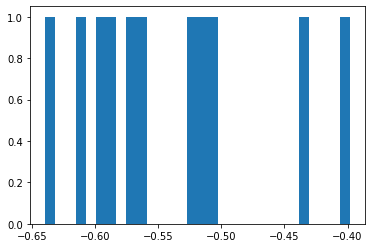

In [ ]:
#plotting histogram of anomaly score
plt.hist(score_anomaly,bins=30)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


-0.5763301566355188


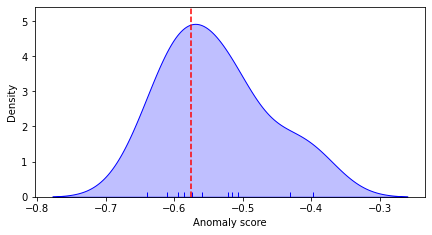

In [ ]:
# Plotting distribution of anomaly scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    score_anomaly,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(model_isof.offset_, c='red', linestyle='--', label='cuantil 0.05')
ax.set_xlabel('Anomaly score')
print(model_isof.offset_)

## Saving anomaly detection results

In [ ]:
df_feat['if_score'] = score_anomaly
df_feat.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,if_score
oid,,,,,,,,,,,,,,,,,
405113200012094,-0.019421,-0.036640,1.555295,1.281783,-1.968677,-0.006785,-0.034409,0.006346,-0.036378,0.034309,-0.058941,0.025057,-0.040508,0.754415,-1.031383,0.012401,-0.610581
464105200007063,0.013039,0.040348,-2.174314,1.389187,1.373868,0.021756,0.003378,-0.007620,0.033752,-0.048393,0.040288,-0.041269,0.010209,-0.264444,0.098123,0.002398,-0.559656
516105400003751,-0.004812,-0.022248,0.782761,-0.180979,0.173506,0.012976,-0.016303,0.020130,0.005639,0.009286,-0.018461,0.024875,-0.007340,1.983115,2.298911,0.036256,-0.515676
629115200005576,0.005211,0.002847,0.081205,2.559672,0.830689,0.049800,-0.053007,0.017275,-0.012348,0.007815,-0.058085,0.009515,-0.046890,2.637215,-1.224063,0.019422,-0.585636
634110400007229,-0.026129,-0.045747,2.656521,2.428572,-2.103093,-0.015175,-0.031090,-0.007545,-0.034387,0.037459,-0.053233,0.017111,-0.031956,0.058569,0.104327,0.017647,-0.639768


In [ ]:
sel_df = df_feat[df_feat.if_score<-0.54]
sel_df.head(50)

,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,if_score
oid,,,,,,,,,,,,,,,,,
405113200012094,-0.019421,-0.036640,1.555295,1.281783,-1.968677,-0.006785,-0.034409,0.006346,-0.036378,0.034309,-0.058941,0.025057,-0.040508,0.754415,-1.031383,0.012401,-0.610581
464105200007063,0.013039,0.040348,-2.174314,1.389187,1.373868,0.021756,0.003378,-0.007620,0.033752,-0.048393,0.040288,-0.041269,0.010209,-0.264444,0.098123,0.002398,-0.559656
629115200005576,0.005211,0.002847,0.081205,2.559672,0.830689,0.049800,-0.053007,0.017275,-0.012348,0.007815,-0.058085,0.009515,-0.046890,2.637215,-1.224063,0.019422,-0.585636
634110400007229,-0.026129,-0.045747,2.656521,2.428572,-2.103093,-0.015175,-0.031090,-0.007545,-0.034387,0.037459,-0.053233,0.017111,-0.031956,0.058569,0.104327,0.017647,-0.639768
843104100009515,0.007981,0.024715,-2.069909,-0.936412,0.564961,0.004367,0.028067,0.005650,0.056105,-0.046374,0.050279,-0.018335,0.029286,0.499199,3.626398,0.029110,-0.595046
861108300005770,0.008811,0.032509,-1.142797,0.510862,1.814281,0.006430,0.022855,-0.015450,0.039402,-0.045526,0.065416,-0.040060,0.033093,-1.219634,1.305871,0.001669,-0.574397


In [ ]:
data['if_score'] = score_anomaly
data.head()

,Unnamed: 0,chi2_gband,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,logsig_e1,logsig_e2,logsig_e3,logsig_e4,logsig_e5,logsig_e6,logsig_e7,logsig_e8,logsig_e9,logsig_e10,logsig_e11,logsig_e12,logsig_e13,logsig_e14,logsig_e15,logsig_e16,if_score
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
405113200012094,0,13.702934,-0.019421,-0.036640,1.555295,1.281783,-1.968677,-0.006785,-0.034409,0.006346,-0.036378,0.034309,-0.058941,0.025057,-0.040508,0.754415,-1.031383,0.012401,0.013559,-0.030243,-2.010220,-3.090810,-1.098368,-0.022051,-0.006376,-0.016476,-0.021834,0.000967,-0.009086,-0.019879,-0.012200,-3.093447,-1.636146,-0.009109,-0.610581
464105200007063,1,11.994704,0.013039,0.040348,-2.174314,1.389187,1.373868,0.021756,0.003378,-0.007620,0.033752,-0.048393,0.040288,-0.041269,0.010209,-0.264444,0.098123,0.002398,-0.016390,-0.023794,-1.848767,-2.917219,-0.955646,0.003677,-0.010442,-0.001627,-0.003605,-0.012198,-0.013912,0.004654,-0.011905,-2.751052,-1.458442,-0.022732,-0.559656
516105400003751,2,10.672771,-0.004812,-0.022248,0.782761,-0.180979,0.173506,0.012976,-0.016303,0.020130,0.005639,0.009286,-0.018461,0.024875,-0.007340,1.983115,2.298911,0.036256,-0.005318,-0.012752,-1.784626,-3.190440,-1.022637,-0.005378,0.006961,0.001216,-0.029050,0.013703,-0.026502,-0.020044,-0.007896,-2.590686,-1.527835,0.006367,-0.515676
629115200005576,3,3.435884,0.005211,0.002847,0.081205,2.559672,0.830689,0.049800,-0.053007,0.017275,-0.012348,0.007815,-0.058085,0.009515,-0.046890,2.637215,-1.224063,0.019422,0.006163,-0.030562,-2.279156,-3.221613,-1.234595,-0.018163,-0.005264,-0.010095,-0.034713,0.000614,-0.018131,-0.020311,-0.012826,-3.256318,-1.950540,-0.009690,-0.585636
634110400007229,4,20.912769,-0.026129,-0.045747,2.656521,2.428572,-2.103093,-0.015175,-0.031090,-0.007545,-0.034387,0.037459,-0.053233,0.017111,-0.031956,0.058569,0.104327,0.017647,-0.007873,-0.068008,-3.477855,-4.640034,-2.646352,-0.042791,-0.019814,-0.018822,-0.051326,-0.012941,-0.022380,-0.037205,-0.029547,-5.061471,-3.178742,-0.021160,-0.639768


In [ ]:
#data.to_csv('/content/drive/MyDrive/CSAGNs/results_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/DR5_final_sample_features_chi2_prederr10_isolation_forest_score_training_with_balqsosample_gband.csv')

In [ ]:
fig = plt.scatter(data.if_score.values,data.n_good_det.values,c=np.log10(data.Autocor_length.values),cmap='gist_heat')
plt.colorbar(fig)
plt.xlabel('IF score')
plt.ylabel('number epochs')

AttributeError: ignored